# Traffic Sign Identification using Deep Neural Networks

## Description
Lorem Ipsum

## Setup and Image Preprocessing

### Imports

In [11]:
import cv2
import pickle
import csv
from skimage import exposure

### Preprocessing Function
Preprocesses images according to passed parameters.

In [12]:
def preprocess_images(file_name, grayscale = False, normalize = False, contrast = False):
    path = './Dataset/'   # Change this for the path corresponding to your base Dataset directory

    img_infos = {'labels':[],'images':[]}

    with open(path+file_name,"r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',', quotechar='|')
        next(reader)
        
        for row in reader:

            img = cv2.imread(path+row[-1], cv2.IMREAD_UNCHANGED) 
            
            if grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image to Grayscale
            
            if contrast:
                img = cv2.addWeighted(img, 1.2, img, 0, 0) #Increase contrast

            if normalize:
                #cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX) #Normalize
                img = exposure.equalize_adapthist(img, clip_limit=0.03)

            img = cv2.resize(img, (32,32),interpolation = cv2.INTER_AREA) #Resize the image to 32x32
            
            img_infos['images'].append(img) #Save Image pixels
            img_infos['labels'].append(row[-2]) #Save image Label
            
    return img_infos

### Save treated data as Pickle
Saves the treated data into Pickle files

In [13]:
# RGB
test_rgb = preprocess_images("Test.csv")
train_rgb = preprocess_images("Train.csv")

with open("./Dataset/PickledData/Test_rgb.p", 'wb') as pickle_rick:
    pickle.dump(test_rgb,pickle_rick)    
print("> Finished writing tests")

with open("./Dataset/PickledData/Train_rgb.p", 'wb') as pickle_rick:
    pickle.dump(train_rgb,pickle_rick)
print("> Finished writing train")

> Finished writing tests
> Finished writing train


## Neural Network

### Step 0 - Imports

In [14]:
import random
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1 - Get the data into the sets

In [15]:
def create_cv_random(x_train, y_train):
    # Get the cross validation set
    x_cv = []
    y_cv = []
    for i in range(int(0.2*len(x_train))): # Randomly move 20% of the training examples into the cross-validation set
        index = random.randint(0, len(x_train)-1)
        x_cv.append(x_train.pop(index))
        y_cv.append(y_train.pop(index))
        
    return x_cv, y_cv

def create_cv_equitative(x_train, y_train):
    label_dic = {}
    for i in range(43):
        label_dic[str(i)] = []
    
    for i in range(len(y_train)):
        label_dic[str(y_train[i])].append(x_train[i])
    
    x_cv = []
    y_cv = []
    for label in label_dic:
        for i in range(int(0.2*len(label_dic[label]))):
            index = random.randint(0, len(label_dic[label]) -1)
            y_cv.append(int(label))
            x_cv.append(label_dic[label].pop(index))
        
    return shuffle(x_cv, y_cv)

def open_set(path_test, path_train, gray = False, cv_random = True):

    with open(path_test, "rb") as f:
        test = pickle.load(f)
    with open(path_train, "rb") as f:
        train = pickle.load(f)

    # Get the training set
    x_train, y_train = train['images'], train['labels']

    # Get the cross validation set
    if cv_random:
        x_cv, y_cv = create_cv_random(x_train, y_train)
    else:
        x_cv, y_cv = create_cv_equitative(x_train, y_train)

    # Get the test set
    x_test, y_test = test['images'], test['labels']

    # Convert all our sets into numPy Arrays
    if gray:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 1))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 1))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 1))
        y_test = keras.utils.to_categorical(np.array(y_test))
    else:
        x_train = np.array(x_train).reshape((len(x_train), 32, 32, 3))
        y_train = keras.utils.to_categorical(np.array(y_train))

        x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 3))
        y_cv = keras.utils.to_categorical(np.array(y_cv))

        x_test = np.array(x_test).reshape((len(x_test), 32, 32, 3))
        y_test = keras.utils.to_categorical(np.array(y_test))
    
    return x_test, y_test, x_train, y_train, x_cv, y_cv

In [321]:
x_test, y_test, x_train, y_train, x_cv, y_cv = open_set("./Dataset/PickledData/Test_rgb.p", "./Dataset/PickledData/Train_rgb.p", cv_random=False)

### Step 2 - Treat the data (Normalize and Shuffle)

In [19]:
# Shuffle the training set
x_train, y_train = shuffle(x_train, y_train)

### Step 3 - Define constants

In [20]:
EPOCHS = 50
BATCH_SIZE = 200
LOSS = keras.losses.categorical_crossentropy
OPT = keras.optimizers.Adam
LEARNING_RATE = 0.002 # Define the learning rate to be used by our optimizer


### Step 4 - Define the Neural Network

In [21]:
def LeNetModel(no_output=6, rgb=True, dropout=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
    
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    # Third Layer - Convolutional ; Input = 14x14x6 ; Output = 10x10x16
    model.add(keras.layers.Conv2D(
                    filters=16, kernel_size=(3, 3),
                    activation='relu'
                    )
                 )
    
    # Fourth Layer - Subsampling (Average Pooling) ; Input = 10x10x16 ; Output = 5x5x16
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))

    # Sixth Layer - Fully Connected ; Input = 120x1 ; Output = 84x1
    model.add(keras.layers.Dense(units=84, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

### Step 5 - Create the model and define evaluation

In [22]:
model = LeNetModel()

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Step 6 - Insert the training set

In [23]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Train on 31368 samples, validate on 7841 samples
Epoch 1/50
31368/31368 [==============================] - 15s 484us/sample - loss: 3.4477 - accuracy: 0.4674 - val_loss: 0.7660 - val_accuracy: 0.7812
Epoch 2/50
31368/31368 [==============================] - 14s 435us/sample - loss: 0.5075 - accuracy: 0.8548 - val_loss: 0.4006 - val_accuracy: 0.8878
Epoch 3/50
31368/31368 [==============================] - 15s 463us/sample - loss: 0.2843 - accuracy: 0.9217 - val_loss: 0.3477 - val_accuracy: 0.9093
Epoch 4/50
31368/31368 [==============================] - 16s 496us/sample - loss: 0.1882 - accuracy: 0.9477 - val_loss: 0.2719 - val_accuracy: 0.9285
Epoch 5/50
31368/31368 [==============================] - 15s 481us/sample - loss: 0.1462 - accuracy: 0.9583 - val_loss: 0.2204 - val_accuracy: 0.9472
Epoch 6/50
31368/31368 [==============================] - 15s 466us/sample - loss: 0.1148 - accuracy: 0.9678 - val_loss: 0.3686 - val_accuracy: 0.9309
Epoch 7/50
31368/31368 [=====================

In [25]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 2s 187us/sample - loss: 1.0838 - accuracy: 0.9094
Test loss: 1.083765682089823
Test accuracy: 0.90942204


## Graphs

### Confusion Matrix

In [224]:
def create_confusion_matrices(y_test, y_predictions):
    #Absolute matrix (number of guesses)
    conf_mat_abs = confusion_matrix(np.argmax(y_test, axis=1), y_predictions)

    #Relative matrix (normalized number of guesses (0-1))
    conf_mat_rel = conf_mat_abs.astype('float') / conf_mat_abs.sum(axis=1)[:, np.newaxis]
    
    return conf_mat_abs, conf_mat_rel

### Confusion Matrix Visualized

In [316]:
def plot_confusion(conf_matrix, title):
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(43)],
                      columns = [i for i in range(43)])
    plt.figure(figsize = (22,22))
    
    ax = sn.heatmap(df_cm, annot=False)
    
    plt.ylabel('Actual Class', fontsize=15)
    plt.xlabel("Guessed Class", fontsize=15)
    
    ax.collections[0].colorbar.set_label("Probability of Guess (%)", fontsize=15)
    plt.title(title,fontsize=18)

    plt.show()

### Histogram of Accuracy per Class

In [310]:
def plot_acc_per_class(conf_mat):
    plt.figure(figsize = (7.25,6))
    plt.bar(range(0,43), [conf_mat_rel[i][i] for i in range(43)], color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('Accuracy of guess (%)',fontsize=12)
    plt.title('Accuracy of model per class',fontsize=15)
    plt.show()

### Histogram of CV Distribution

In [278]:
def plot_cv_per_class(y_cv, y_train):
    plt.figure(figsize = (20,7))
    
    plt.subplot(1,2,1)
    plt.hist(np.argmax(y_cv, axis=1), bins = range(0,43), color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the CV Set',fontsize=15)
    
    plt.subplot(1,2,2)
    plt.hist(np.argmax(y_train, axis=1), bins = range(0,43), color="#731f58")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('# of elements in set',fontsize=12)
    plt.title('Distribution of elements per class in the Train Set',fontsize=15)


    plt.show()

## Discussion of Results


### 1 - RGB

#### Conf Mat

[[ 38  12   0 ...   0   0   0]
 [  0 678  21 ...   0   0   0]
 [  0   7 702 ...   0   0   0]
 ...
 [  0   1   0 ...  78   0   0]
 [  0   0   0 ...   0  47   0]
 [  0   0   0 ...   0   4  78]]


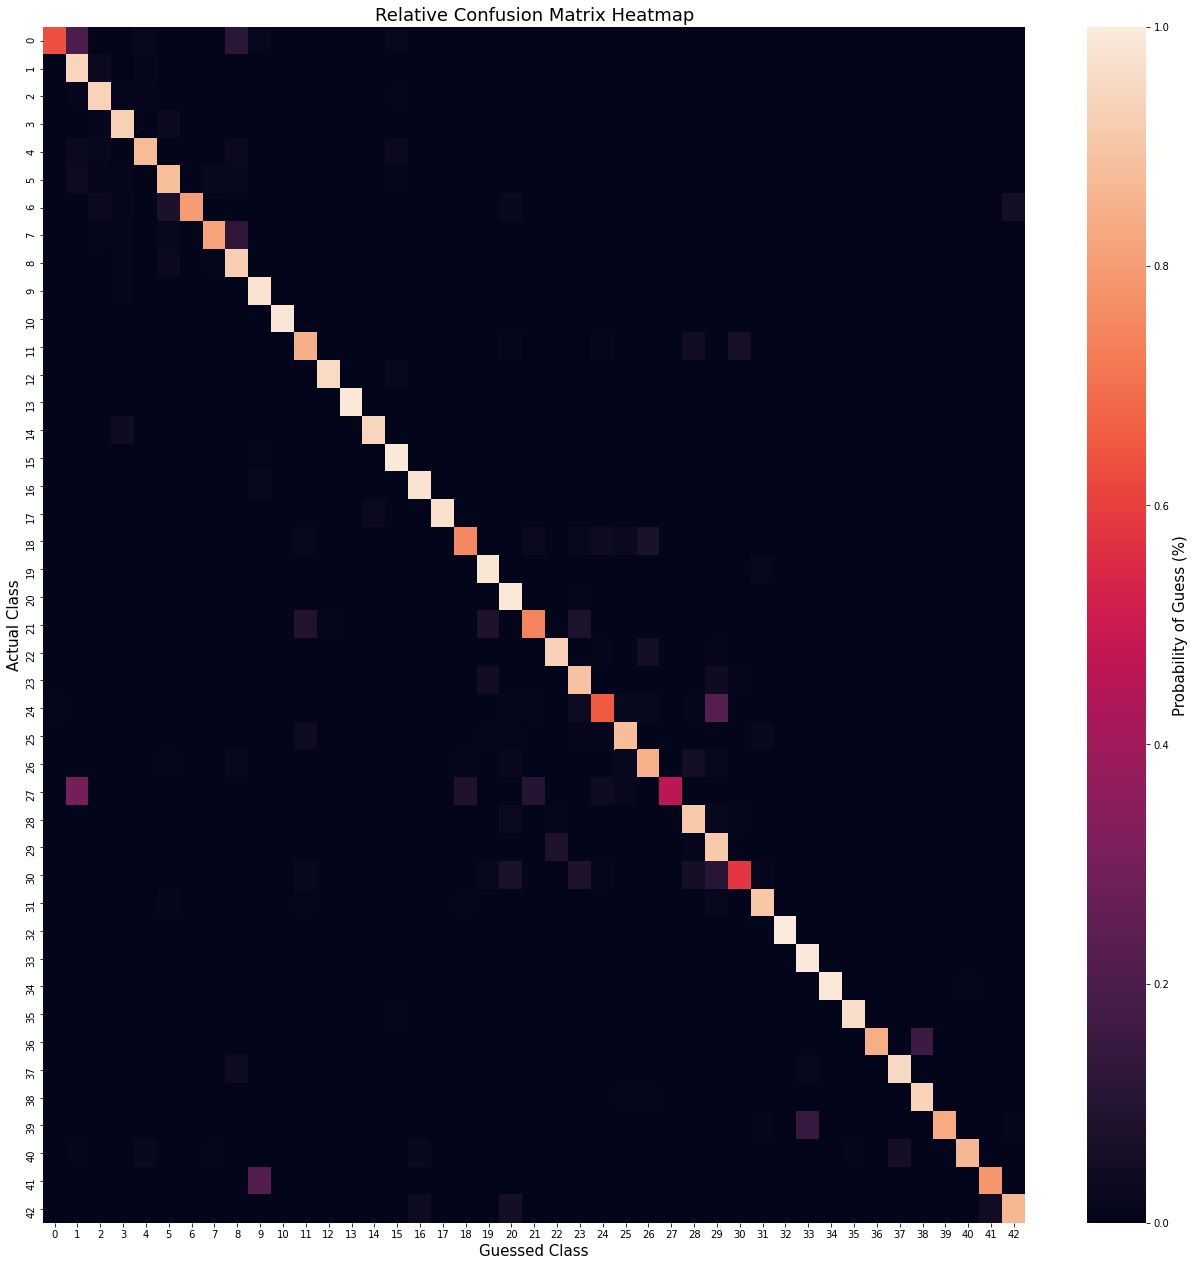

In [318]:
conf_mat_abs, conf_mat_rel = create_confusion_matrices(y_test, y_predictions)

print(conf_mat_abs)
plot_confusion(conf_mat_rel, "Relative Confusion Matrix Heatmap")

#### Accuracy per class

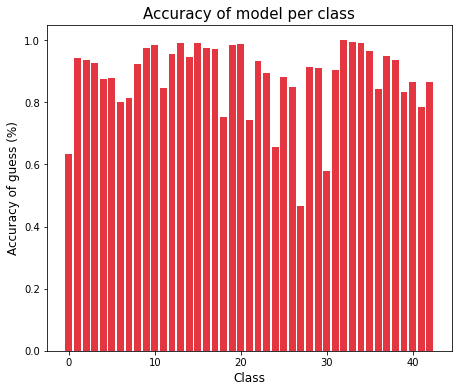

In [311]:
plot_acc_per_class(conf_mat_rel)

### 2 - CV
We noticed that when picking the CV set's elements just by getting 20% of the elements of the total training set we could cause our CV to contain little to no data from some classes, and too much from others. So we changed it in order to assure that our CV is constitued of 20% of each of the train set's classes' data.
As a result, the graph representing the distribution of number of elements per class in each set should be more similar

#### CV Class Distribution with Random

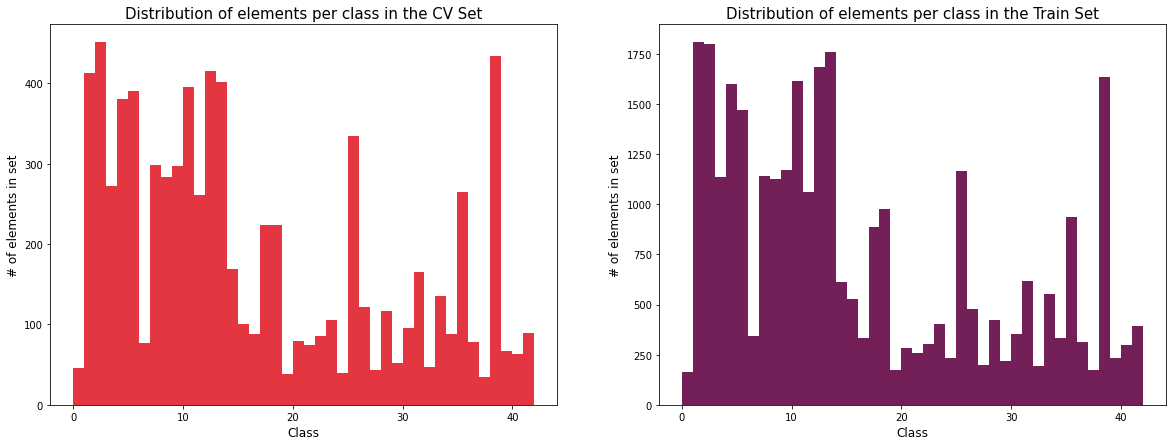

In [279]:
plot_cv_per_class(y_cv,y_train)

#### CV Class Distribution with Equalization

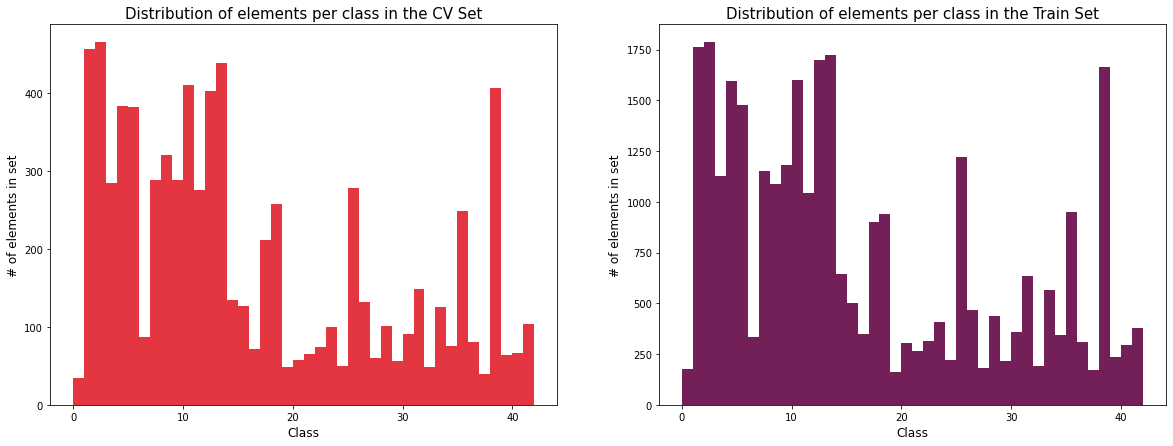

In [324]:
plot_cv_per_class(y_cv,y_train)

### 3 - Grayscale
Depois decidimos normalizar

### 4 - Normalize
Depois decidimos normalizar

### 5 - Contrast
Depois decidimos alterar o contraste das imagens

### 6 - Data Augmentation

### 7 - Epochs


### 8 - Optimizing Function


### 9 - Loss Function


### 10 - Learning Rate

### 11 - Dropout